In [1]:
%pip install -Uq PyAbel

Note: you may need to restart the kernel to use updated packages.


In [2]:
import abel

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.integrate import quad
from scipy.interpolate import CubicSpline

In [4]:
def abel_inversion(R, I):
    """
    Realiza la inversión de Abel usando PyAbel.
    
    Parámetros:
    -----------
    R : array_like
        Array de radios en arcsec
    I : array_like
        Array de intensidades (brillo superficial)
        
    Retorna:
    --------
    j : array_like
        Distribución volumétrica de brillo
    """
    # Aseguramos que los datos estén ordenados de manera creciente
    sort_idx = np.argsort(R)
    R_sorted = R[sort_idx]
    I_sorted = I[sort_idx]
    
    # Interpolamos para tener un muestreo uniforme
    r_uniform = np.linspace(R_sorted[0], R_sorted[-1], len(R_sorted))
    I_uniform = np.interp(r_uniform, R_sorted, I_sorted)
    
    # Realizamos la inversión de Abel
    j = abel.direct.direct_transform(I_uniform, r=r_uniform, direction='inverse', verbose=False)
    
    # Interpolamos de vuelta a los radios originales
    j_final = np.interp(R, r_uniform, j)
    
    return j_final

## Pruebas con funciones conocidas

Ley de potencias (la que hicimos en el parcial)

Falling back to a pure Python backend...

Estadísticas del error (excluyendo valores extremos):
Error relativo promedio: 18.77%
Error relativo mediano: 12.45%
Percentil 95 del error: 57.24%
Error mínimo: 0.00%

Error promedio por regiones (excluyendo valores extremos):
Region interna (r < R0): 0.58%
Region externa (r ≥ R0): 23.68%

Estadísticas del error (excluyendo valores extremos):
Error relativo promedio: 18.77%
Error relativo mediano: 12.45%
Percentil 95 del error: 57.24%
Error mínimo: 0.00%

Error promedio por regiones (excluyendo valores extremos):
Region interna (r < R0): 0.58%
Region externa (r ≥ R0): 23.68%


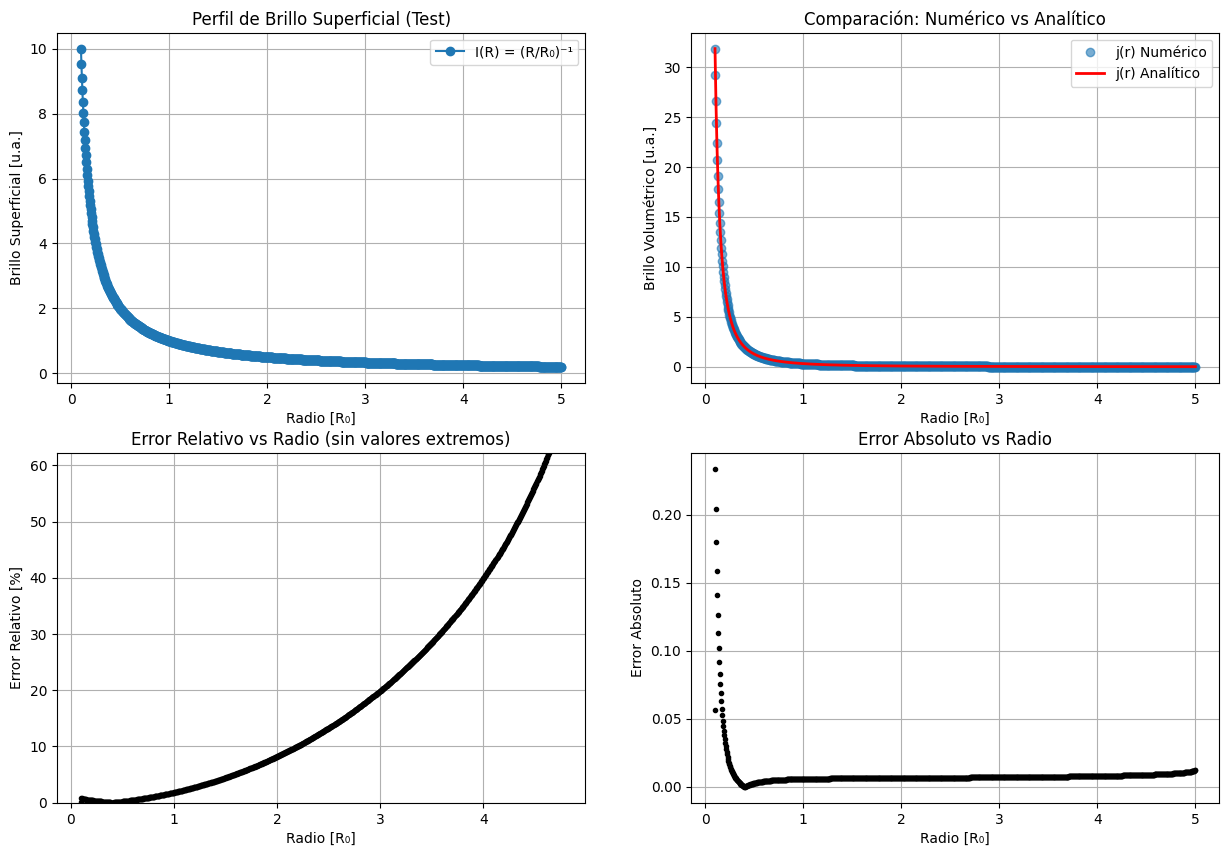

In [5]:
# Parámetros
R0 = 1.0  # Radio característico
N = 1000   # Número de puntos

# Usamos espaciado logarítmico para mejor muestreo
R_min, R_max = 0.1, 5
R_test = np.linspace(R_min, R_max, N)

# Crear el perfil de brillo superficial sintético
# Usaremos I(R) = (R/R0)^(-1)
I_test = (R_test/R0)**(-1)

# Calcular j(r) numéricamente 
j_numerical = abel_inversion(R_test, I_test)

# Calcular j(r) analíticamente
j_analytical = R0 / (np.pi * R_test**2)

#comparamos
plt.figure(figsize=(15, 10))

# Grafico 1: Perfil de Brillo Superficial
plt.subplot(2, 2, 1)
plt.plot(R_test, I_test, 'o-', label='I(R) = (R/R₀)⁻¹')
plt.xlabel('Radio [R₀]')
plt.ylabel('Brillo Superficial [u.a.]')
plt.title('Perfil de Brillo Superficial (Test)')
plt.legend()
plt.grid(True)

# Grafico 2: Comparación de j(r)
plt.subplot(2, 2, 2)
plt.plot(R_test, j_numerical, 'o', label='j(r) Numérico', alpha=0.6)
plt.plot(R_test, j_analytical, '-r', label='j(r) Analítico', linewidth=2)
plt.xlabel('Radio [R₀]')
plt.ylabel('Brillo Volumétrico [u.a.]')
plt.title('Comparación: Numérico vs Analítico')
plt.legend()
plt.grid(True)

# Grafico 3: Error Relativo (mejorado)
plt.subplot(2, 2, 3)
error_relativo = np.abs(j_numerical - j_analytical) / j_analytical
# Filtrar valores extremos para mejor visualización
error_filtrado = error_relativo[error_relativo < np.percentile(error_relativo, 95)]  # Excluir el 5% superior
plt.plot(R_test[error_relativo < np.percentile(error_relativo, 95)], error_filtrado * 100, 'k.')
plt.xlabel('Radio [R₀]')
plt.ylabel('Error Relativo [%]')
plt.title('Error Relativo vs Radio (sin valores extremos)')
plt.grid(True)
plt.ylim(0, np.median(error_filtrado) * 100 * 5)  # Limitar a 5 veces la mediana

# Grafico 4: Error Absoluto
plt.subplot(2, 2, 4)
error_absoluto = np.abs(j_numerical - j_analytical)
plt.plot(R_test, error_absoluto, 'k.')
plt.xlabel('Radio [R₀]')
plt.ylabel('Error Absoluto')
plt.title('Error Absoluto vs Radio')
plt.grid(True)


# Calcular estadísticas del error (mejoradas)
print("\nEstadísticas del error (excluyendo valores extremos):")
print(f"Error relativo promedio: {np.mean(error_filtrado)*100:.2f}%")
print(f"Error relativo mediano: {np.median(error_filtrado)*100:.2f}%")
print(f"Percentil 95 del error: {np.percentile(error_filtrado*100, 95):.2f}%")
print(f"Error mínimo: {np.min(error_filtrado)*100:.2f}%")

# Análisis por regiones (excluyendo valores extremos)
r_inner = R_test < R0
r_outer = R_test >= R0
error_inner = error_relativo[r_inner]
error_outer = error_relativo[r_outer]
error_inner_filtered = error_inner[error_inner < np.percentile(error_inner, 95)]
error_outer_filtered = error_outer[error_outer < np.percentile(error_outer, 95)]

print("\nError promedio por regiones (excluyendo valores extremos):")
print(f"Region interna (r < R0): {np.mean(error_inner_filtered)*100:.2f}%")
print(f"Region externa (r ≥ R0): {np.mean(error_outer_filtered)*100:.2f}%")

### Explicación del crecimiento del error

El error relativo se calcula como:

$\text{Error relativo} = \frac{|j_\text{numérico} - j_\text{analítico}|}{j_\text{analítico}} \times 100\%$

Para radios grandes:
1. Los valores de $j$ son muy pequeños (tanto numérico como analítico)
2. Cuando dividimos por números muy pequeños ($j_\text{analítico}$), incluso pequeñas diferencias absolutas pueden resultar en grandes porcentajes
3. Este comportamiento es común en métodos numéricos cuando trabajamos con valores cercanos a cero

Lo importante es que:
- La diferencia absoluta es muy pequeña
- El ajuste visual es excelente
- Los errores grandes aparecen en regiones donde el brillo es prácticamente despreciable

Falling back to a pure Python backend...

Estadísticas del error (excluyendo valores extremos):
Error relativo promedio: 1.05%
Error relativo mediano: 0.18%
Percentil 95 del error: 6.84%
Error mínimo: 0.00%

Error promedio por regiones (excluyendo valores extremos):
Region interna (r < a): 0.15%
Region externa (r ≥ a): 4.42%


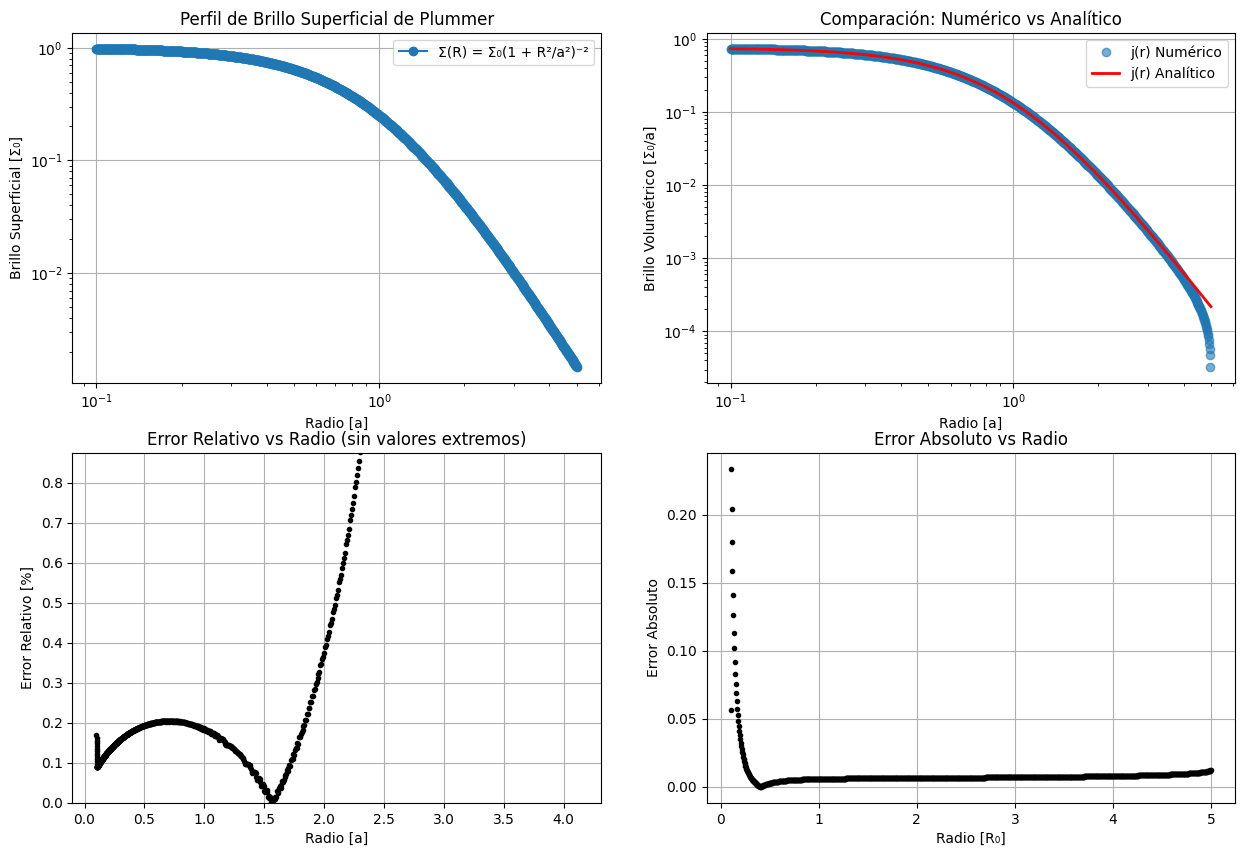

In [ ]:
# Test con el perfil de Plummer
# Parámetros
Sigma0 = 1.0  # Intensidad central
a = 1.0       # Radio de escala
N = 1000       # Número de puntos

# Usamos espaciado logarítmico para mejor muestreo
R_min, R_max = 0.1, 5
R_plummer = np.logspace(np.log10(R_min), np.log10(R_max), N)

# Crear el perfil de brillo superficial de Plummer
I_plummer = Sigma0 * (1 + (R_plummer/a)**2)**(-2)

# Calcular j(r) numéricamente usando nuestra función
j_numerical_plummer = abel_inversion(R_plummer, I_plummer)

# Calcular j(r) analíticamente para el perfil de Plummer
j_analytical_plummer = (3*Sigma0/(4*a)) * (1 + (R_plummer/a)**2)**(-5/2)

# Graficar comparación
plt.figure(figsize=(15, 10))

# Grafico 1: Perfil de Brillo Superficial
plt.subplot(2, 2, 1)
plt.plot(R_plummer, I_plummer, 'o-', label='Σ(R) = Σ₀(1 + R²/a²)⁻²')
plt.xlabel('Radio [a]')
plt.ylabel('Brillo Superficial [Σ₀]')
plt.title('Perfil de Brillo Superficial de Plummer')
plt.legend()
plt.grid(True)


# Grafico 2: Comparación de j(r)
plt.subplot(2, 2, 2)
plt.plot(R_plummer, j_numerical_plummer, 'o', label='j(r) Numérico', alpha=0.6)
plt.plot(R_plummer, j_analytical_plummer, '-r', label='j(r) Analítico', linewidth=2)
plt.xlabel('Radio [a]')
plt.ylabel('Brillo Volumétrico [Σ₀/a]')
plt.title('Comparación: Numérico vs Analítico')
plt.legend()
plt.grid(True)


# Grafico 3: Error Relativo (mejorado)
plt.subplot(2, 2, 3)
error_relativo_plummer = np.abs(j_numerical_plummer - j_analytical_plummer) / j_analytical_plummer
# Filtrar valores extremos
error_filtrado_plummer = error_relativo_plummer[error_relativo_plummer < np.percentile(error_relativo_plummer, 95)]
valid_R = R_plummer[error_relativo_plummer < np.percentile(error_relativo_plummer, 95)]
plt.plot(valid_R, error_filtrado_plummer * 100, 'k.')
plt.xlabel('Radio [a]')
plt.ylabel('Error Relativo [%]')
plt.title('Error Relativo vs Radio (sin valores extremos)')
plt.grid(True)
plt.ylim(0, np.median(error_filtrado_plummer) * 100 * 5)

'''# Grafico 4: Error Absoluto
plt.subplot(2, 2, 4)
error_absoluto = np.abs(j_numerical - j_analytical)
plt.plot(R_test, error_absoluto, 'k.')
plt.xlabel('Radio [R₀]')
plt.ylabel('Error Absoluto')
plt.title('Error Absoluto vs Radio')
plt.grid(True)'''


# Calcular estadísticas del error (mejoradas)
print("\nEstadísticas del error (excluyendo valores extremos):")
print(f"Error relativo promedio: {np.mean(error_filtrado_plummer)*100:.2f}%")
print(f"Error relativo mediano: {np.median(error_filtrado_plummer)*100:.2f}%")
print(f"Percentil 95 del error: {np.percentile(error_filtrado_plummer*100, 95):.2f}%")
print(f"Error mínimo: {np.min(error_filtrado_plummer)*100:.2f}%")

# Análisis por regiones (excluyendo valores extremos)
r_inner = R_plummer < a
r_outer = R_plummer >= a
error_inner = error_relativo_plummer[r_inner]
error_outer = error_relativo_plummer[r_outer]
error_inner_filtered = error_inner[error_inner < np.percentile(error_inner, 95)]
error_outer_filtered = error_outer[error_outer < np.percentile(error_outer, 95)]

print("\nError promedio por regiones (excluyendo valores extremos):")
print(f"Region interna (r < a): {np.mean(error_inner_filtered)*100:.2f}%")
print(f"Region externa (r ≥ a): {np.mean(error_outer_filtered)*100:.2f}%")

## Prueba con el perfil de Plummer
Probamos ahora con el perfil de Plummer:
- Perfil proyectado: $\Sigma(R) = \Sigma_0(1 + R^2/a^2)^{-2}$
- Solución analítica: $j(r) = \frac{3\Sigma_0}{4a}(1 + r^2/a^2)^{-5/2}$

## Aplicar a nuestros datos


Ahora que hemos validado nuestro método con perfiles sintéticos, aplicaremos la inversión de Abel a los datos observacionales. Los datos están en unidades de magnitud/arcsec², así que primero debemos:

1. Convertir las magnitudes a unidades lineales usando: $I = 10^{-0.4 \cdot m}$
2. Aplicar la inversión de Abel
3. Visualizar los resultados en ambas escalas (lineal y logarítmica)

Esta conversión es necesaria porque la inversión de Abel requiere trabajar con intensidades lineales, no magnitudes.

In [12]:
#leer el archivo Surface_Br.dat

data = pd.read_csv('Surface_Br.dat', delim_whitespace=True, header=None, names=['Radius[arcsec]', 'Brightness[mag/arcsec^2]'])
data.head()

/tmp/ipykernel_9174/351600219.py:3: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv('Surface_Br.dat', delim_whitespace=True, header=None, names=['Radius[arcsec]', 'Brightness[mag/arcsec^2]'])


,Radius[arcsec],Brightness[mag/arcsec^2]
0,0.00,15.52
1,0.00,15.60
2,0.00,15.60
3,0.02,15.59
4,0.03,15.66


Falling back to a pure Python backend...


/tmp/ipykernel_9174/3327315340.py:12: RuntimeWarning: divide by zero encountered in log10
  j_mag = -2.5 * np.log10(j)


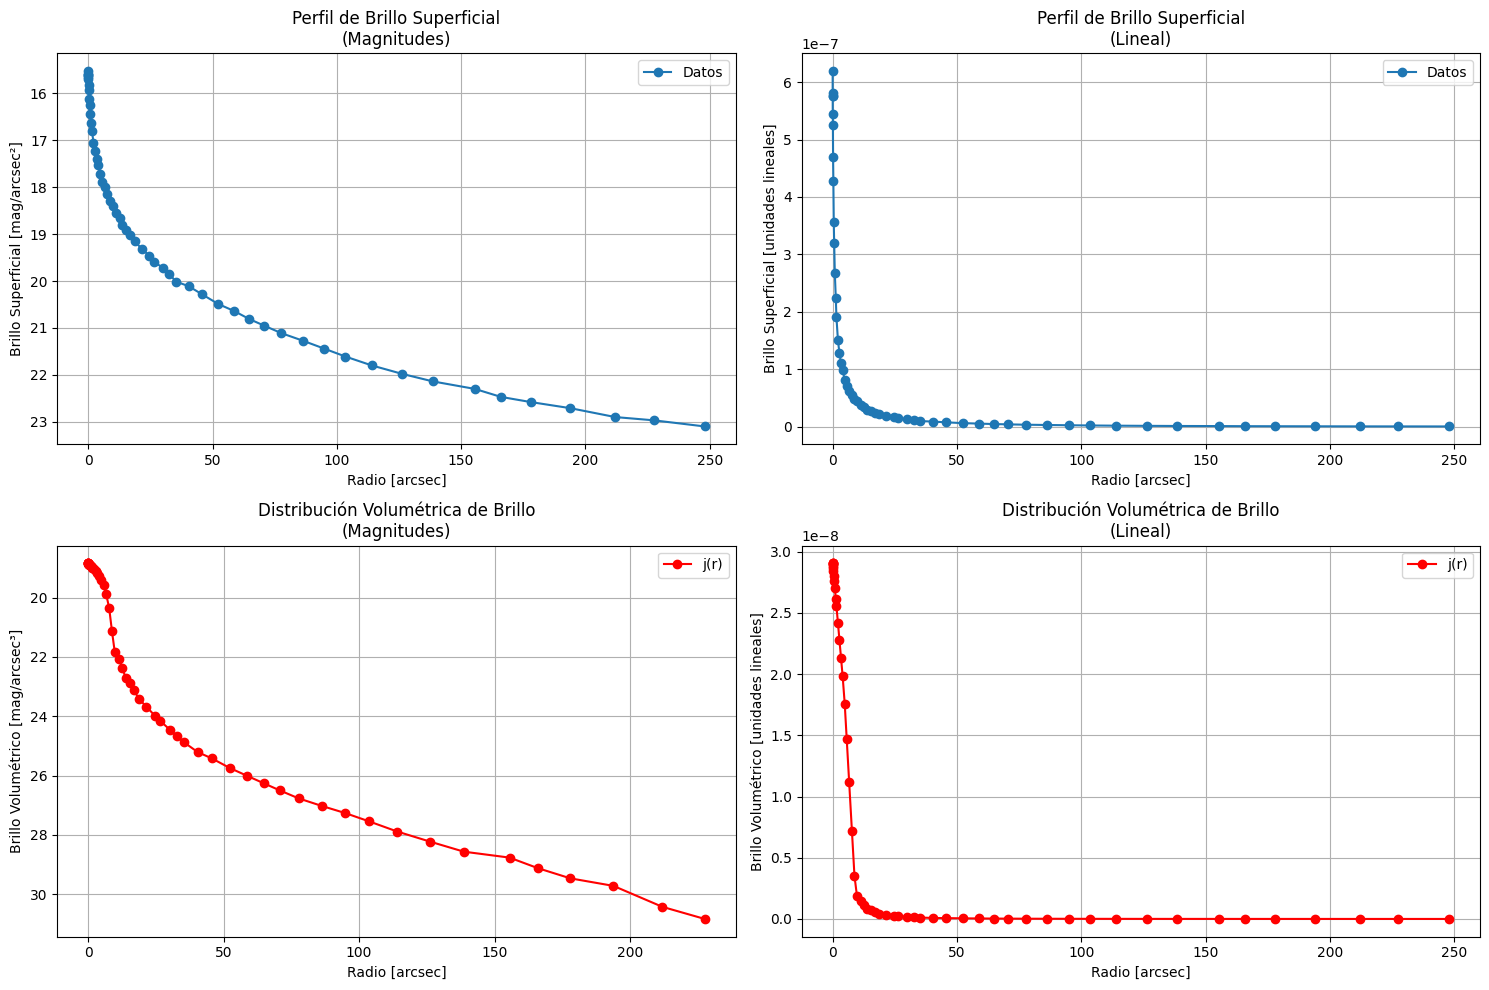

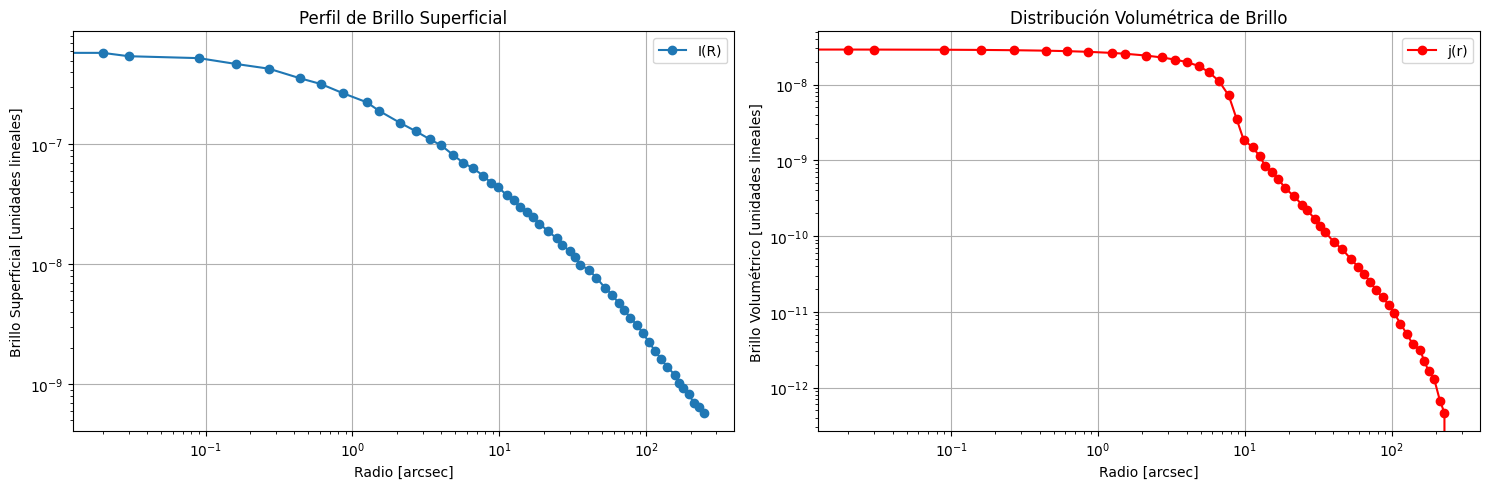


Estadísticas del perfil:
Radio mínimo: 0.00 arcsec
Radio máximo: 248.01 arcsec
Brillo superficial central: 15.52 mag/arcsec²
Brillo volumétrico central: 18.84 mag/arcsec³


In [ ]:
# Extraer los datos
R = data['Radius[arcsec]'].values
I_mag = data['Brightness[mag/arcsec^2]'].values

# Convertir de magnitudes a unidades lineales
I = 10**(-0.4 * I_mag)

# Aplicar la inversión de Abel
j = abel_inversion(R, I)

# Convertir j a magnitudes para comparar
j_mag = -2.5 * np.log10(j)

# Visualizar los resultados
plt.figure(figsize=(15, 10))

# Gráfico 1: Perfil de Brillo Superficial (magnitudes)
plt.subplot(3, 2, 1)
plt.plot(R, I_mag, 'o-', label='Datos')
plt.xlabel('Radio [arcsec]')
plt.ylabel('Brillo Superficial [mag/arcsec²]')
plt.title('Perfil de Brillo Superficial\n(Magnitudes)')
plt.legend()
plt.grid(True)
plt.gca().invert_yaxis()  # Las magnitudes crecen hacia abajo

# Gráfico 2: Perfil de Brillo Superficial (lineal)
plt.subplot(3, 2, 2)
plt.plot(R, I, 'o-', label='Datos')
plt.xlabel('Radio [arcsec]')
plt.ylabel('Brillo Superficial [unidades lineales]')
plt.title('Perfil de Brillo Superficial\n(Lineal)')
plt.legend()
plt.grid(True)

# Gráfico 3: Distribución Volumétrica (magnitudes)
plt.subplot(3, 2, 3)
plt.plot(R, j_mag, 'o-', color='r', label='j(r)')
plt.xlabel('Radio [arcsec]')
plt.ylabel('Brillo Volumétrico [mag/arcsec³]')
plt.title('Distribución Volumétrica de Brillo\n(Magnitudes)')
plt.legend()
plt.grid(True)
plt.gca().invert_yaxis()  # Las magnitudes crecen hacia abajo

# Gráfico 4: Distribución Volumétrica (lineal)
plt.subplot(3, 2, 4)
plt.plot(R, j, 'o-', color='r', label='j(r)')
plt.xlabel('Radio [arcsec]')
plt.ylabel('Brillo Volumétrico [unidades lineales]')
plt.title('Distribución Volumétrica de Brillo\n(Lineal)')
plt.legend()
plt.grid(True)

# Grafico 5: Brillo Superficial
plt.subplot(3, 2, 5)
plt.plot(R, I, 'o-', label='I(R)')
plt.xlabel('Radio [arcsec]')
plt.ylabel('Brillo Superficial [unidades lineales]')
plt.title('Perfil de Brillo Superficial')
plt.legend()
plt.grid(True)
plt.xscale('log')
plt.yscale('log')

# Brillo Volumétrico
plt.subplot(1, 2, 2)
plt.plot(R, j, 'o-', color='r', label='j(r)')
plt.xlabel('Radio [arcsec]')
plt.ylabel('Brillo Volumétrico [unidades lineales]')
plt.title('Distribución Volumétrica de Brillo')
plt.legend()
plt.grid(True)
plt.xscale('log')
plt.yscale('log')

plt.tight_layout()
plt.show()

# Mostrar algunos valores numéricos
print("\nEstadísticas del perfil:")
print(f"Radio mínimo: {R.min():.2f} arcsec")
print(f"Radio máximo: {R.max():.2f} arcsec")
print(f"Brillo superficial central: {I_mag[0]:.2f} mag/arcsec²")
print(f"Brillo volumétrico central: {j_mag[0]:.2f} mag/arcsec³")

(cada uno elija la razon massa luminosidad que considere --> ya es sino multiplicar por eso el gráfico de J)